In [19]:
import pandas as pd
import re
import string
import numpy as np
import seaborn as sn
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.utils.data_utils import pad_sequences

In [2]:
#clean data
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)  
    text=text.replace('» 100percentfedUp.com','')
    text=text.replace('- ABC News', '')
    text=text.replace('- CNNPolitics.com', '')
    text=text.replace('- CNN.com', '')
    text = text.replace('[^A-Za-z0-9\s]','')
    return text

In [3]:
#data 1

real=pd.read_csv('news\\True.csv')
real['label']= 1
fake=pd.read_csv('news\\Fake.csv')
fake['label']= 0

data=pd.concat([fake, real], axis=0)
data = data.sample(frac=1).reset_index(drop=True)
data['text']= data['title']+' '+data['text']
data.drop(['title','subject','date'], axis=1, inplace=True)

#data 2 (big)
data2_train = pd.read_csv('news\\Fake or Real News Dataset\\train.csv')
data2_test = pd.read_csv('news\\Fake or Real News Dataset\\test.csv')
data2=pd.concat([data2_train, data2_test], axis=0)

data2['text']=data2['text;label'].apply(lambda x: x.split(';')[0])
data2['label']=data2['text;label'].apply(lambda x: x.split(';')[1]).astype(int)
data2.drop('text;label', axis=1, inplace=True)

data2=pd.concat([data, data2], axis=0)
data2 = data2.sample(frac=1).reset_index(drop=True)

#data 3 (bigger)
data3_train = pd.read_csv('news\\Fake News Detection Dataset\\train.csv')
data3_test = pd.read_csv('news\\Fake News Detection Dataset\\test.csv')
data3=pd.concat([data3_train, data3_test], axis=0)

data3['text']=data3['text;label'].apply(lambda x: x.split(';')[0])
data3['label']=data3['text;label'].apply(lambda x: x.split(';')[1]).astype(int)
data3.drop('text;label', axis=1, inplace=True)

data3=pd.concat([data3, data2], axis=0)
data3 = data3.sample(frac=1).reset_index(drop=True)

#data 4 (even bigger)
data4 =pd.read_csv('news\\More_news\\train.csv')
data4['text'] = data4['title']+' '+data4['text']
data4['text'] = data4['text'].astype(str)
data4['label']=data4['label'].astype(int)
data4['label']= data4['label'].replace([1,0],[0,1])
data4.drop(['title','author','id'], axis=1, inplace=True)

data4=pd.concat([data3, data4], axis=0)
data4 = data4.sample(frac=1).reset_index(drop=True)

#data 5 (biggest)
data5_real=pd.read_csv('news\\cnn\\clean_true_data.csv', encoding = "ISO-8859-1")
data5_real['label']= 1
data5_fake=pd.read_csv('news\\cnn\\clean_fake_data.csv', encoding = "ISO-8859-1")
data5_fake['label']=0

data5_real = data5_real[['text','title','label']]
data5_fake = data5_fake[['text','title','label']]

data5=pd.concat([data5_fake, data5_real], axis=0)
data5 = data5.sample(frac=1).reset_index(drop=True)
data5['title']=data5['title'].apply(lambda x: wordopt(x))
data5['text']= data5['title']+' '+data5['text']
data5.drop(['title'], axis=1, inplace=True)
data5['text'] = data5['text'].astype(str)
data5['label'] = data5['label'].astype(int)

data5 = pd.concat([data4, data5], axis=0)
data5 = data5.sample(frac=1).reset_index(drop=True)

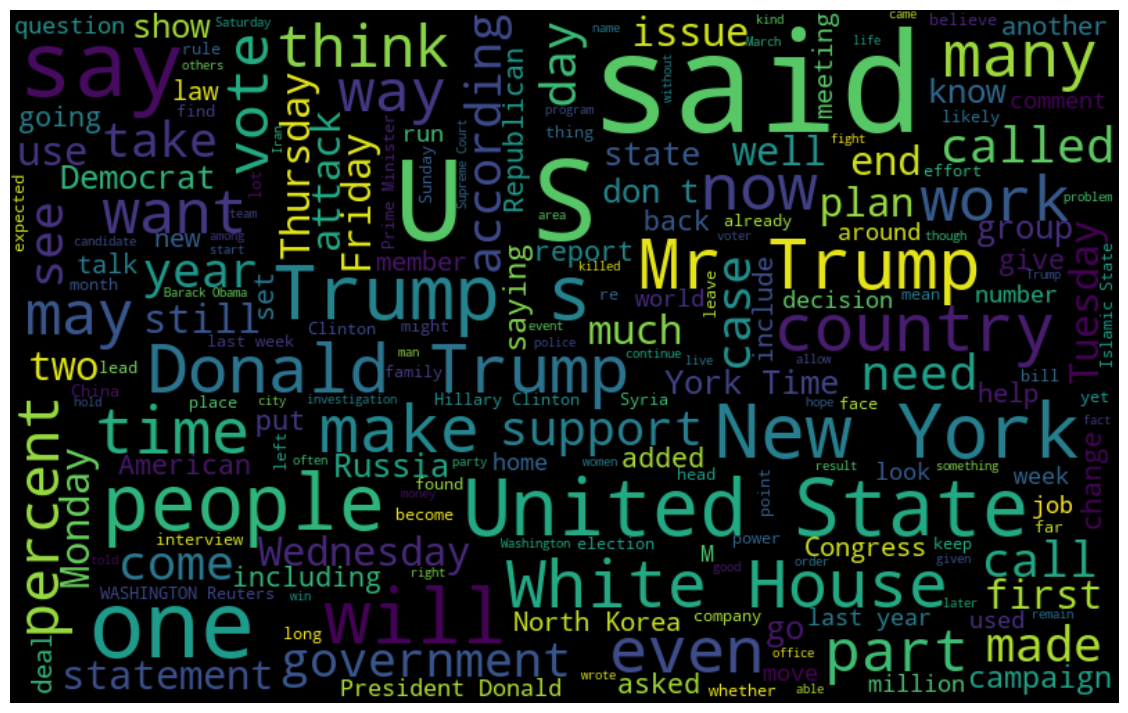

In [4]:
#visualize the frequent words for real news
all_words = " ".join([sentence for sentence in data5['text'][data5['label']==1]])
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

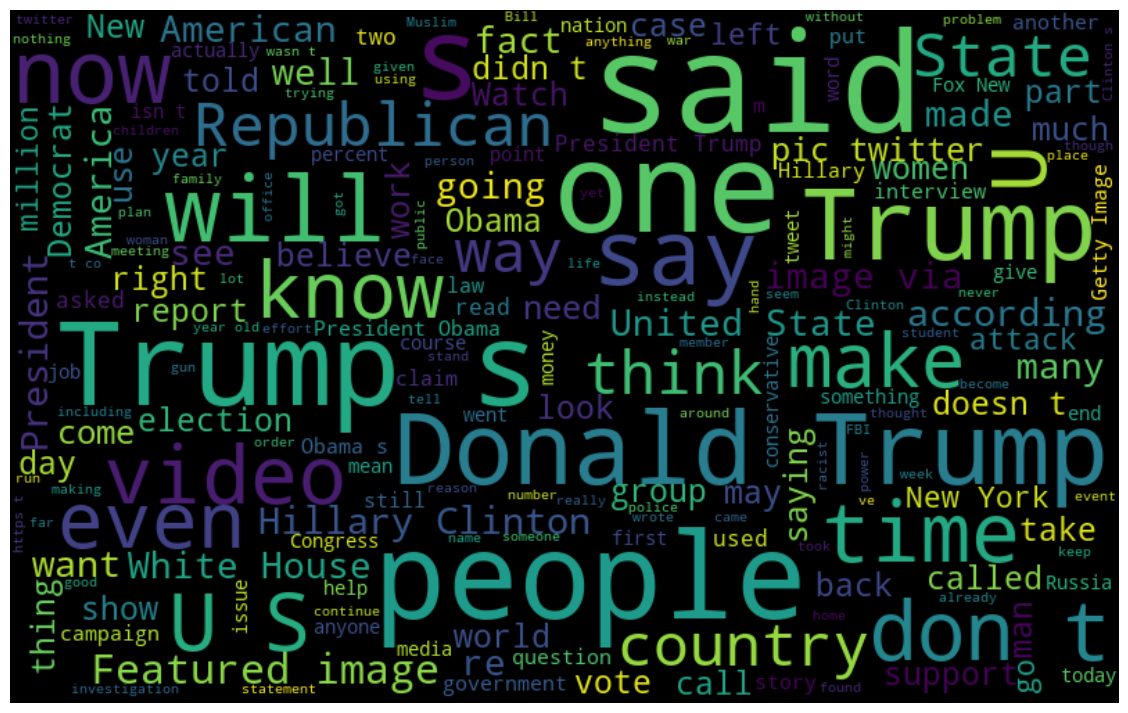

In [5]:
#visualize the frequent words for fake news
all_words = " ".join([sentence for sentence in data['text'][data['label']==0]])
wordcloud = WordCloud(width = 800, height = 500, random_state = 42, max_font_size = 100).generate(all_words)

#plot the graph
plt.figure(figsize=(15,9))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [6]:
# tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['text'])
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

147708

In [7]:
labels=data.label
labels.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [8]:
data.shape
data.head()

,text,label
0,Democratic appointed appeals judges to review ...,1
1,Flames raced along train at west London statio...,1
2,France's Macron trades barbs for diplomacy wit...,1
3,Zimbabwe's Mugabe: Beware of death on road to ...,1
4,Britain declines to comment on reported death ...,1


In [9]:
# padding data
sequences = tokenizer.texts_to_sequences(data['text'])
padded_seq = pad_sequences(sequences, maxlen=500, padding='post', truncating='post')

In [10]:
# create embedding index
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

In [11]:
# create embedding matrix
embedding_matrix = np.zeros((vocab_size+1, 100))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [12]:
#Model Training

In [13]:
x_train, x_test, y_train, y_test = train_test_split(padded_seq, data['label'], test_size=0.20, random_state=42, stratify=data['label'])

In [14]:
from keras.layers import LSTM, Dropout, Dense, Embedding
from keras import Sequential

model = Sequential([
    Embedding(vocab_size+1, 100, weights=[embedding_matrix], trainable=False),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(256),
    Dense(1, activation='sigmoid')
])

In [15]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         14770900  
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 14,921,429
Trainable params: 150,529
Non-t

In [16]:
# train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test))

Epoch 1/10
141/141 [==============================] - 295s 2s/step - loss: 0.6046 - accuracy: 0.6787 - val_loss: 0.5143 - val_accuracy: 0.7696
Epoch 2/10
141/141 [==============================] - 305s 2s/step - loss: 0.4360 - accuracy: 0.8341 - val_loss: 0.3340 - val_accuracy: 0.8934
Epoch 3/10
141/141 [==============================] - 311s 2s/step - loss: 0.4312 - accuracy: 0.8220 - val_loss: 0.6206 - val_accuracy: 0.6333
Epoch 4/10
141/141 [==============================] - 309s 2s/step - loss: 0.4893 - accuracy: 0.7599 - val_loss: 0.3231 - val_accuracy: 0.8949
Epoch 5/10
141/141 [==============================] - 310s 2s/step - loss: 0.4298 - accuracy: 0.8440 - val_loss: 0.3009 - val_accuracy: 0.9063
Epoch 6/10
141/141 [==============================] - 310s 2s/step - loss: 0.3863 - accuracy: 0.8669 - val_loss: 0.3946 - val_accuracy: 0.8617
Epoch 7/10
141/141 [==============================] - 314s 2s/step - loss: 0.3477 - accuracy: 0.8772 - val_loss: 0.4881 - val_accuracy: 0.6463

In [17]:
print("Evaluate model on test data")
results = model.evaluate(x_test, y_test)
print("Loss - Accuracy:", results)

Evaluate model on test data
281/281 [==============================] - 30s 108ms/step - loss: 0.3100 - accuracy: 0.8742
Loss - Accuracy: [0.30998191237449646, 0.8741648197174072]


In [18]:
#PassiveAggressiveClassifier

NameError: name 'PassiveAggressiveClassifier' is not defined

In [20]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

model = PassiveAggressiveClassifier(max_iter=100)

In [21]:
model.fit(x_train, y_train)

PassiveAggressiveClassifier(max_iter=100)

In [22]:
y_pred=model.predict(x_test)
score=accuracy_score(y_test,y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 56.16%
